In [5]:
from myLibrary.vocab import Vocab

import pandas as pd
import random
import torch
import torch.nn as nn
from  torch.utils.data import Dataset, DataLoader
import re
import pickle

import matplotlib.pyplot as plt

In [3]:
train_corpus = pd.read_csv('data/train.csv')
test_corpus = pd.read_csv('data/test.csv')

In [7]:
vocab = Vocab(train_corpus)
with open('data/vocab.pkl', 'wb') as file:
    pickle.dump(vocab, file)

In [36]:
def generating_sequences_and_targets_LSTM(data):
    features_list = []
    targets_list = []

    data = data['Clear'].str.split().values
    for sentence in data:
        for i in range(len(sentence)-1):
            features = sentence[:i+1]
            target = sentence[i+1]
            features_list.append(features)
            targets_list.append(target)

    time = pd.DataFrame({'Features': features_list, 'Targets': targets_list})
    return time

In [37]:
train_data = generating_sequences_and_targets_LSTM(train_corpus)
test_data = generating_sequences_and_targets_LSTM(test_corpus)

In [38]:
class QuotesDataset(Dataset):
    def __init__(self, data, vocab : Vocab):
        self.X = pd.DataFrame(data['Features'])
        self.y = data['Targets']
        self.vocab = vocab

    def __len__(self):
        return len(self.X)

    def vectorize(self, quote_list):
        word_list = quote_list.values[0]
        vector = [self.vocab.token_to_idx.get(word, 0) for word in word_list]
        vector = (self.vocab.max_seq_len -len(vector)) * [0] + vector
        return torch.tensor(vector)

    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]), torch.tensor(self.vocab.token_to_idx.get(self.y[idx], 0))

In [39]:
train_dataset = QuotesDataset(train_data, vocab)
test_dataset = QuotesDataset(test_data, vocab)

train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(train_dataset, batch_size=16)

In [40]:
iteration = iter(train_dataloader)
xt, yt = next(iteration)
print(xt[0], yt[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1]) tensor(2710)


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
class MyLSTMModel(nn.Module):
  def __init__(self, input_size, embedding_dim, hidden_size,
               output_size, num_layers, dropout_p):
    super(MyLSTMModel, self).__init__()
    self.embedding = nn.Embedding(input_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True,
                        bidirectional=True, dropout=dropout_p)
    self.fc = nn.Linear(hidden_size * 2, output_size)

  def forward(self, x):
    embedded = self.embedding(x)
    out, _ = self.lstm(embedded)
    out = self.fc(out[:, -1, :])
    return out


In [43]:
INPUT_SIZE = vocab.vocab_len
OUTPUT_SIZE = vocab.vocab_len
EMBEDDING_DIM = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT_P = 0.5
BATCH_SIZE = 16

In [44]:
model = MyLSTMModel(INPUT_SIZE,
                    EMBEDDING_DIM,
                    HIDDEN_SIZE,
                    OUTPUT_SIZE,
                    NUM_LAYERS,
                    DROPOUT_P).to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
def fit(model, criterion, train_dataloader, valid_dataloader, max_epochs, lr=0.0003):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    accuracy = {"train": [], "valid": []}
    model_loss = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            epoch_loss = []
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    if random.randint(1, 3) == 2:
                      win_batch = x_batch
                    model.eval()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)


                epoch_loss.append(loss.item())

                preds = outp.argmax(-1)
                correct = preds[preds == y_batch].size(0)
                all = y_batch.size(0)
                epoch_correct += correct
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1} ", end=' ')

            last_loss = sum(epoch_loss)/len(epoch_loss)
            print(f"{k}-loss: {last_loss:.4}", end=' ')
            print(f"{k}-accuracy: {epoch_correct/epoch_all:.4}", end=' ')
            accuracy[k].append(epoch_correct/epoch_all)
            model_loss[k].append(last_loss)
            if k == "valid" and last_loss == min(model_loss["valid"]):
                torch.save(model.state_dict(), 'best.pth')

        print()
        if win_batch is None:
          win_batch = x_batch
        random_sent = win_batch[random.randint(0, len(x_batch)-1)].clone()
        list_of_tokens = random_sent.tolist()
        flag = False
        for i in range(10):
            pred = model(random_sent.view(1, -1))
            pred_token = pred.argmax()
            list_of_tokens.append(pred_token.item())
            random_sent = torch.tensor(list_of_tokens[-len(random_sent):], device='cuda:0')
        for token in list_of_tokens:
            if token != 0 or flag:
                flag = True
                print(vocab.idx_to_token[token], end=' ')

        torch.save(model.state_dict(), 'last.pth')
        print()
    return model_loss, accuracy

In [ ]:
loss, accuracy = fit(model, criterion, train_dataloader, test_dataloader, max_epochs=100)

Epoch: 1  train-loss: 6.969 train-accuracy: 0.144 valid-loss: 6.398 valid-accuracy: 0.1535 
<BOS> каждый жизненный опыт ставит этот вопрос как ты хочешь измениться из-за меня <EOS> <BOS> я не <EOS> <BOS> я не <EOS> <BOS> 
Epoch: 2  train-loss: 5.826 train-accuracy: 0.1597 valid-loss: 6.163 valid-accuracy: 0.1548 
<BOS> для меня предмет это нечто живое эта сигарета или этот коробок спичек содержат тайную жизнь гораздо более насыщенную чем у некоторых человеческих <EOS> <BOS> я не могу <EOS> <BOS> я не могу 
Epoch: 3  train-loss: 5.151 train-accuracy: 0.1685 valid-loss: 6.035 valid-accuracy: 0.1613 
<BOS> счастливых голодных игр что такое в конце концов что такое это было не 
Epoch: 4  train-loss: 4.483 train-accuracy: 0.1865 valid-loss: 5.625 valid-accuracy: 0.1751 
<BOS> для меня предмет это нечто живое знают что определенный в таком важном вопросе что определенный 
Epoch: 5  train-loss: 3.854 train-accuracy: 0.2433 valid-loss: 5.251 valid-accuracy: 0.195 
<BOS> дети прекрасно знают чт

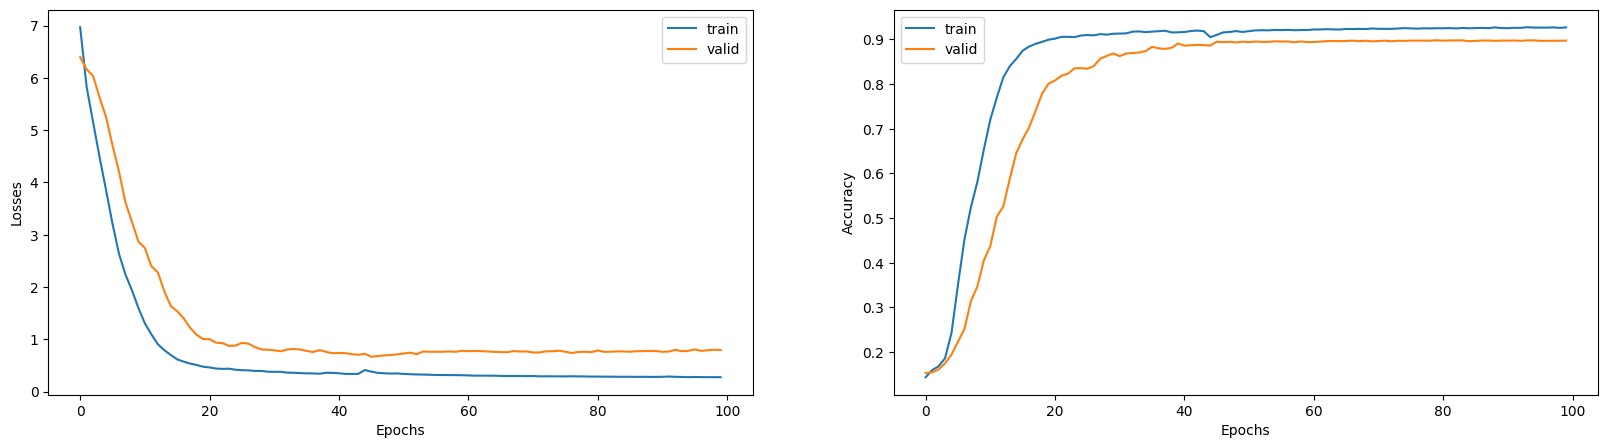

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(loss['train'], label='train')
ax1.plot(loss['valid'], label='valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses')
ax1.legend()

ax2.plot(accuracy['train'], label='train')
ax2.plot(accuracy['valid'], label='valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


In [46]:
model.load_state_dict(torch.load('best.pth', map_location=torch.device('cpu')))
model.eval()

MyLSTMModel(
  (embedding): Embedding(5841, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=5841, bias=True)
)

In [48]:
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^а-я0-9 -]', '', text)
    text = text.replace(' - ', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [86]:
def generate_text(string):
    string = f'<BOS> {preprocessing(string)}'
    tokens = string.split()
    list_of_tokens = [vocab.token_to_idx.get(word, 0) for word in tokens]
    list_of_tokens = (vocab.max_seq_len -len(list_of_tokens)) * [0] + list_of_tokens
    random_sent = torch.tensor(list_of_tokens)
    
    for i in range(10):
        pred = model(random_sent.view(1, -1))
        pred_token = pred.argmax()
        list_of_tokens.append(pred_token.item())
        string += f' {vocab.idx_to_token[pred_token.item()]}'
        random_sent = torch.tensor(list_of_tokens[-len(random_sent):])

    string = string.replace(' <EOS>', '.')
    string = string.replace('<BOS> ', '')

    sentences = string.split('.')
    sentences = [sentence.strip().capitalize() for sentence in sentences if sentence]
    punct_string = '. '.join(sentences) + '.'
    return punct_string


In [87]:
beginning = input()
generate_text(beginning)

'Русь должна быть великой и ненавязчивой такой которая проникает в душу.'

In [88]:
beginning = input()
generate_text(beginning)

'Не тот кто волк а тот кто учится у нее чертовски хорошее чувство юмора. В.'

In [89]:
beginning = input()
generate_text(beginning)

'Был бы ты человеком что-то из жизни можно построить здание суда разума или его.'

In [90]:
beginning = input()
generate_text(beginning)

'Математика это слова которые нужно написать. Что касается ли мучо.'